<a href="https://colab.research.google.com/github/nirmit27/ml-notebooks/blob/main/ML/KMeans_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Means** Clustering

### Importing the necessary modules

In [ ]:
!pip install feature-engine

In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from feature_engine.outliers import Winsorizer

import scipy.stats as stats
from sklearn.cluster import KMeans

### Importing the dataset

In [3]:
df = pd.read_excel(r"/content/University.xlsx")
df.head()

,Univ,State,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,Brown,RI,1310,89,22,13,22704,94
1,CalTech,CA,1415,100,25,6,63575,81
2,CMU,PA,1260,62,59,9,25026,72
3,Columbia,NY,1310,76,24,12,31510,88
4,Cornell,NY,1280,83,33,13,21864,90


## Data **Preprocessing**

#### Information about the columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Univ      25 non-null     object
 1   State     25 non-null     object
 2   SAT       25 non-null     int64 
 3   Top10     25 non-null     int64 
 4   Accept    25 non-null     int64 
 5   SFRatio   25 non-null     int64 
 6   Expenses  25 non-null     int64 
 7   GradRate  25 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 1.7+ KB


#### Numerical features

In [5]:
df_num = df.select_dtypes(exclude="object")
df_num.head()

,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,1310,89,22,13,22704,94
1,1415,100,25,6,63575,81
2,1260,62,59,9,25026,72
3,1310,76,24,12,31510,88
4,1280,83,33,13,21864,90


#### Categorical features

In [6]:
df_cat = df.select_dtypes(include="object")
df_cat.head()

,Univ,State
0,Brown,RI
1,CalTech,CA
2,CMU,PA
3,Columbia,NY
4,Cornell,NY


#### Checking for **missing** values

In [7]:
df.isna().sum()

Univ        0
State       0
SAT         0
Top10       0
Accept      0
SFRatio     0
Expenses    0
GradRate    0
dtype: int64

> There is **no** need for missing value imputation for the given dataset.

#### Outlier visualization
> before **winsorization**

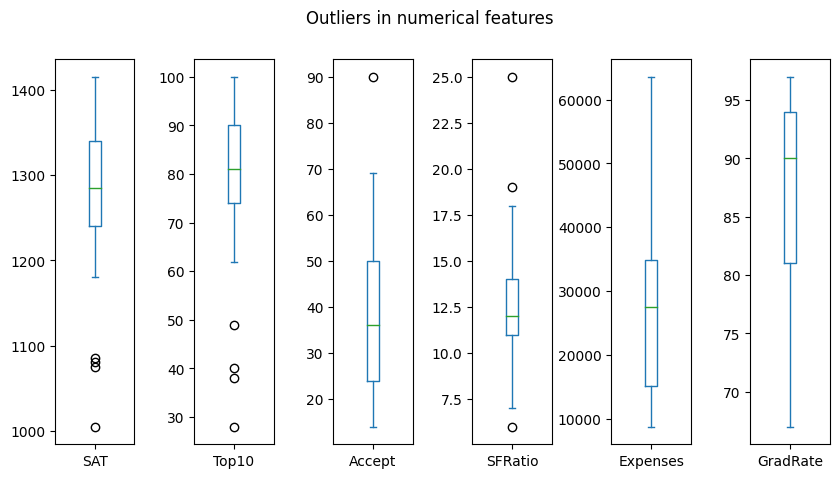

In [8]:
df_num.plot(kind='box', subplots=True, figsize=(10, 5), sharey=False, title="Outliers in numerical features")
plt.subplots_adjust(wspace=0.75)
plt.show()

> There are outliers present in every numerical column except for `Expenses` and `GradRate`.

#### Winsorization
> for the treatment of **outliers**, using the `IQR` capping method

In [9]:
def winsorize(column: str):
  winsorizer = Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=[column])
  df_num[column] = winsorizer.fit_transform(df_num[[column]])

In [10]:
for column in df_num.columns:
  winsorize(df_num[column].name)

#### Outlier visualization
> after **winsorization**

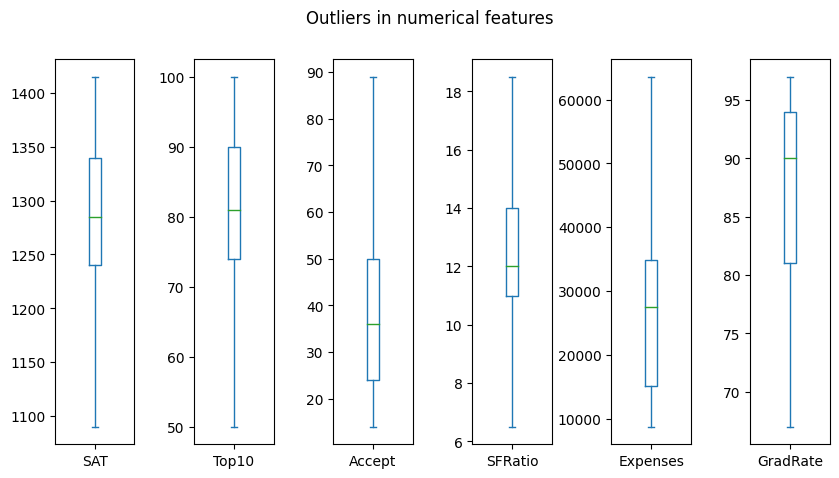

In [11]:
df_num.plot(kind='box', subplots=True, figsize=(10, 5), sharey=False, title="Outliers in numerical features")
plt.subplots_adjust(wspace=0.75)
plt.show()

### Dummy variables
> generating **dummy** variable column for the categorical features

#### Unique values

In [18]:
df_cat['State'].unique(), df_cat['Univ'].unique()

(array(['RI', 'CA', 'PA', 'NY', 'NH', 'NC', 'DC', 'MA', 'MD', 'IL', 'IN',
        'NJ', 'TX', 'MI', 'VA', 'WI', 'CT'], dtype=object),
 array(['Brown', 'CalTech', 'CMU', 'Columbia', 'Cornell', 'Dartmouth',
        'Duke', 'Georgetown', 'Harvard', 'JohnsHopkins', 'MIT',
        'Northwestern', 'NotreDame', 'PennState', 'Princeton', 'Purdue',
        'Stanford', 'TexasA&M', 'UCBerkeley', 'UChicago', 'UMichigan',
        'UPenn', 'UVA', 'UWisconsin', 'Yale'], dtype=object))

> Taking into consideration the `State` column for dummy variables since it will be used for clustering based on geographical location.

In [22]:
df_cat = pd.get_dummies(df_cat, columns=['State'], drop_first=True)
df_cat.head()

,Univ,State_CT,State_DC,State_IL,State_IN,State_MA,State_MD,State_MI,State_NC,State_NH,State_NJ,State_NY,State_PA,State_RI,State_TX,State_VA,State_WI
0,Brown,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,CalTech,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,CMU,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,Columbia,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,Cornell,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


## **EDA**

### Distribution
> plotting the distribution of numerical columns using **KDE** plots

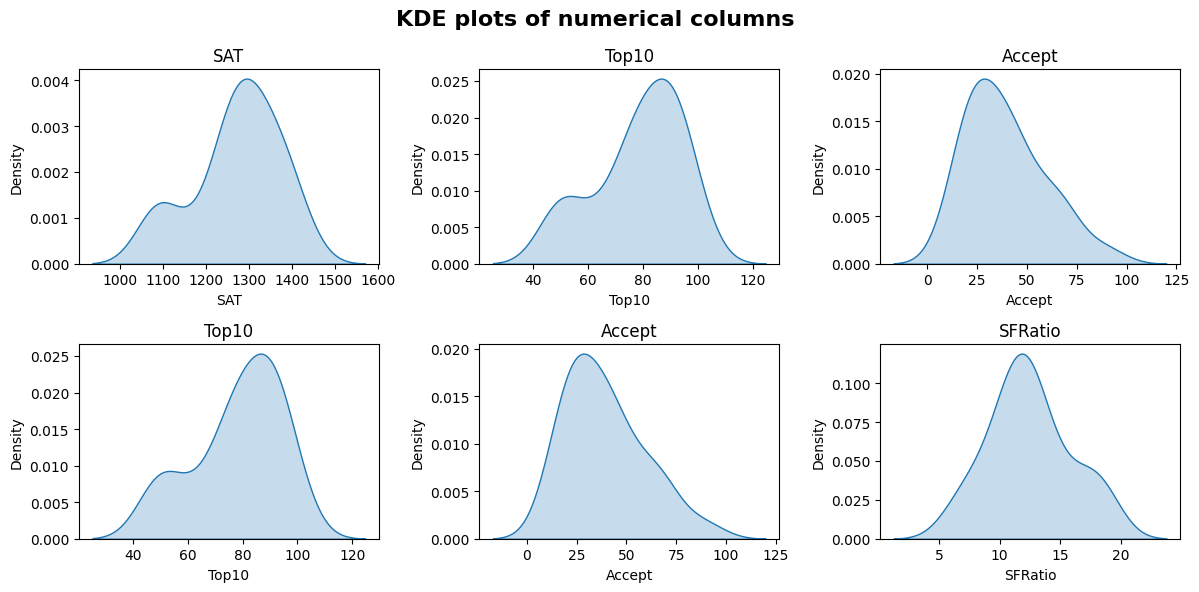

In [78]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle("KDE plots of numerical columns", fontweight='bold', fontsize=16)

for i in range(2):
  for j in range(3):
    sns.kdeplot(df_num, x=df_num.columns[i + j], fill=True, ax=axs[i][j])
    axs[i][j].set_title(df_num.columns[i + j], fontsize=12)

plt.tight_layout()
plt.show()

#### Univariate Normality
> checking the **univariate normality** of the numerical columns using `normal quantile` **Q-Q** plot

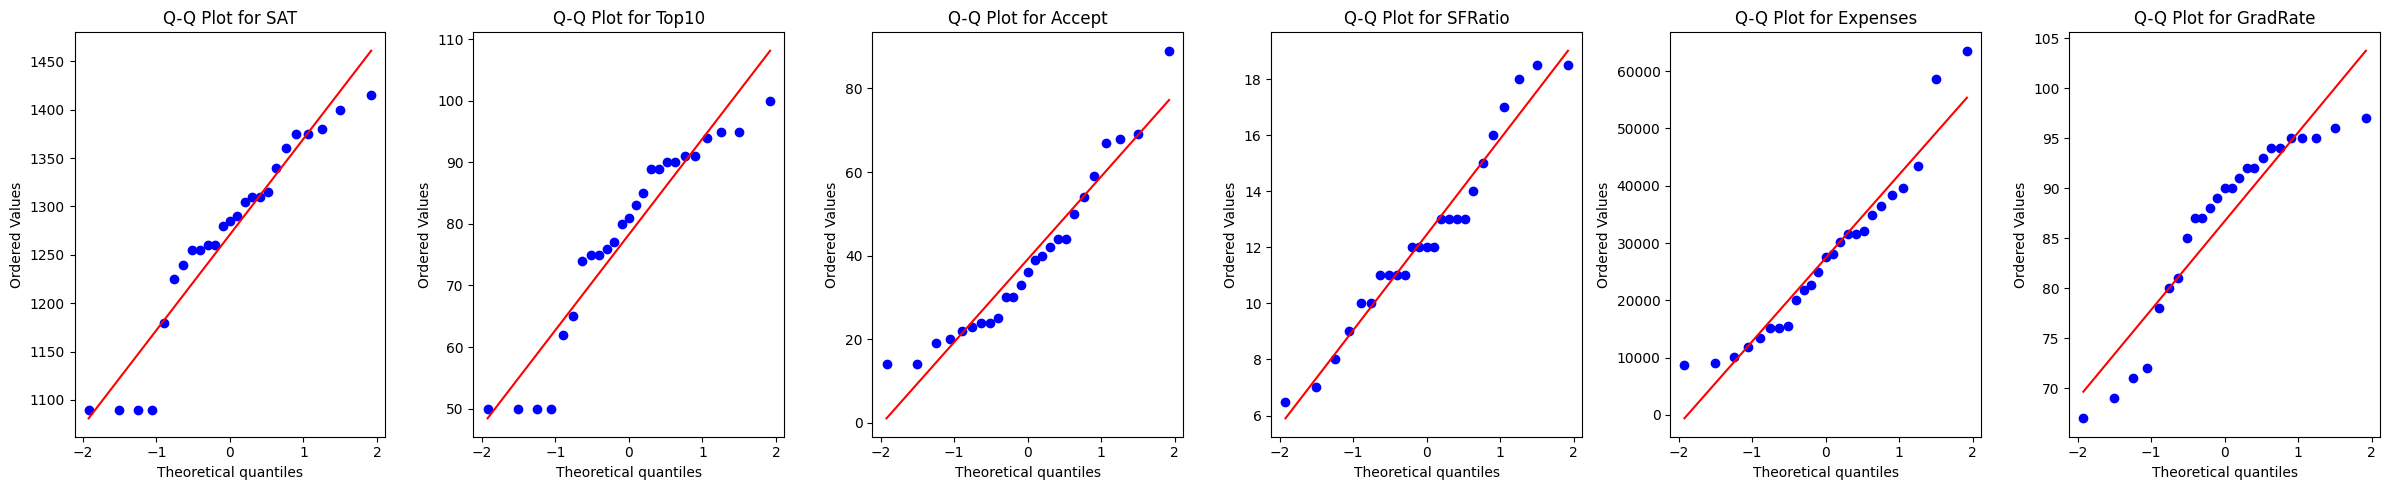

In [49]:
num_cols = len(df_num.columns)

fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(4 * num_cols, 5))

for i, column in enumerate(df_num.columns):
    stats.probplot(df_num[column], dist='norm', plot=axs[i])
    axs[i].set_title(f'Q-Q Plot for {column}')

plt.tight_layout()
plt.show()

###